<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 6</strong>
</div>
<div style="text-align: center;">
<strong>Solving PDEs with Neural Nets (a further look)</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)

# 1 Setting up PINNs

In this section of the notebook, we revisit the elements of PC5 that enable the definition of neural networks, 1D and 2D grids. You can copy the code you implemented for PC5 notebook.

# 1.1 Neural network class

### Exercise

{exercise}
Complete the missing parts in the creation of the neural network model (from pc5).

In [3]:
def create_model(neurons, *, input_size=1, output_size=1, activation="tanh", initializer="glorot_normal"):
    """
    Creates a Sequential Keras model with the specified parameters.

        Parameters
        ----------
        neurons : list of int
            A list where each element represents the number of neurons in a hidden layer.
        input_size : int, optional
            The size of the input layer. Default is 1.
        output_size : int, optional
            The size of the output layer. Default is 1.
        activation : str, optional
            The activation function to use for the hidden layers. Default is 'tanh'.
        initializer : str, optional
            The initializer for the kernel weights matrix. Default is 'glorot_normal'.

        Returns
        -------
        tf.keras.Sequential
            A Keras Sequential model with the specified architecture.
    """

    # Setup model:
    model = tf.keras.Sequential()

    # Input layer:
    model.add(tf.keras.layers.InputLayer(input_shape=(input_size,)))  

    # Loop over hidden layers:
    for dl in neurons:
        model.add(tf.keras.layers.Dense(dl, activation=activation, kernel_initializer=initializer))

    # Output layer:
    model.add(tf.keras.layers.Dense(output_size, activation=None))
    model.num_output = output_size

    return model

# 1.2 Grids in 1D

### Exercise

{exercise}
Complete the missing parts in the creation of the 1D grid (from pc5).

In [4]:
def grid1D(n_r, dom, gridtype):
    """
    Generates a 1D grid of points based on the specified grid type.

    Parameters
    ----------
    n_r : int
        The number of points in the grid.
    dom : tuple of float
        The domain limits (lower bound, upper bound).
    gridtype : str
        The type of grid to generate. Options are:
        - 'rand': Randomly distributed points in the domain.
        - 'uniform': Equally spaced points in the domain.
        - 'midpoint': Midpoints of a uniform grid.

    Returns
    -------
    x_r : tf.Tensor
        The grid points of shape (n_r, 1).
    x_b : tf.Tensor
        The boundary points of shape (2,), corresponding to `dom[0]` and `dom[1]`.

    Notes
    -----
    - The random grid uses `tf.random.uniform` to sample points from a uniform distribution.
    - The uniform grid uses `tf.linspace` to create evenly spaced points.
    - The midpoint grid is computed as the midpoints of a uniform grid.
    - The output tensors are cast to `DTYPE`.
    """
    
    if gridtype == 'rand':
        
        x_r = tf.random.uniform(shape=(n_r, 1), minval=dom[0], maxval=dom[1])
        
    elif gridtype == 'uniform':
        
        x_r = tf.linspace(dom[0],dom[1], n_r+1)
        
    elif gridtype == 'midpoint':
        
        x_r = tf.linspace(dom[0], dom[1], n_r + 1)
        x_r = 1/2*(x_r[0:n_r] + x_r[1:n_r + 1])
        x_r = tf.reshape(x_r, (n_r, 1))

    x_r = tf.cast(x_r, dtype=DTYPE)
    x_b = tf.constant([dom[0], dom[1]], dtype=DTYPE)

    return x_r, x_b

# 1.3 Grids in 2D

### Exercise

{exercise}
Complete the missing parts in the creation of the 2D grid (from pc5).

In [5]:
def grid2D(n_r, n_b, n_i, dom):
    """
    Generates a 2D grid of points for solving PDEs on a rectangular domain.

    Parameters
    ----------
    n_r : int
        The number of residual points inside the domain.
    n_b : int
        The number of boundary points along each spatial boundary.
    n_i : int
        The number of initial condition points.
    dom : tuple of float
        The domain limits in the form (t_min, t_max, x_min, x_max).

    Returns
    -------
    X_r : tf.Tensor
        The residual points of shape (n_r, 2), representing (t, x) pairs.
    X_b : tf.Tensor
        The boundary points of shape (n_i + 2*n_b, 2), representing (t, x) pairs.
    u_b : tf.Tensor
        The boundary condition values at the boundary points of shape (n_i + 2*n_b, 1).

    Notes
    -----
    - The domain is defined as `[t_min, t_max] x [x_min, x_max]`.
    - Residual points `(t_r, x_r)` are sampled uniformly from the domain.
    - Boundary points include:
        - Initial condition = left boundary (`t_min`, varying `x`).
        - Boundary conditions = top and bottom boudaries (`x_min`, varying `t` and `x_max`, varying `t`).
    - The function `u0(x)` provides the initial condition values at `t_min`.
    """

    # PDE is on [t_min, t_max] x [x_min, x_max]:
    t_min = dom[0]
    t_max = dom[1]
    x_min = dom[2]
    x_max = dom[3]

    # Residual points in time:
    t_r = tf.random.uniform(shape=(n_r, 1), minval=t_min, maxval=t_max, dtype=DTYPE)

    # Residual points in space:
    x_r = tf.random.uniform((n_r, 1), minval=x_min, maxval=x_max, dtype=DTYPE)

    # Residual points in time and space:
    X_r = tf.concat([t_r, x_r], axis=1)

    # Boundary points in time:
    t_left = tf.random.uniform((n_i, 1), minval=t_min, maxval=t_min, dtype=DTYPE) #essayer tf.ones pr voir si meilleure erreur
    t_top = tf.random.uniform((n_b, 1), minval=t_min, maxval=t_max, dtype=DTYPE)
    t_bottom = tf.random.uniform((n_b, 1), minval=t_min, maxval=t_max, dtype=DTYPE)
    t_b = tf.concat([t_left, t_top, t_bottom], axis=0)

    # Boundary points in space:
    x_left = tf.random.uniform((n_i, 1), minval=x_min, maxval=x_max, dtype=DTYPE)
    x_top = tf.random.uniform((n_b, 1), minval=x_min, maxval=x_min, dtype=DTYPE)
    x_bottom = tf.random.uniform((n_b, 1), minval=x_max, maxval=x_max, dtype=DTYPE)
    x_b = tf.concat([x_left, x_top, x_bottom], axis=0)

    # Boundary points in time and space:
    X_b = tf.stack([t_b, x_b], axis=1)

    # Boundary data:
    u_left = u0(x_left)
    u_top = 0 * t_top
    u_bottom = 0 * t_bottom
    u_b = tf.concat([u_left, u_top, u_bottom], axis=0)
    u_b = tf.constant(u_b, shape=(n_i + 2 * n_b, 1))

    return X_r, X_b, u_b

# 2 Deep Ritz method

We consider the one-dimensional Poisson equation with non-homogeneous Dirichlet boundary conditions:

\begin{align}
& -u''(x) = f(x), \quad x \in(-1,1), \\
& u(-1) = u_L = 3/2,
\\
&u(+1) = u_R = -1/2.
\end{align}

We will take the following right-hand side and exact solution,

$$
f(x) = -1 + \omega^2\sin(\omega x), \quad u(x) = \frac{x^2}{2} + \sin(\omega x), \quad \omega = 3\pi/2.
$$

We want to approximate the solution of this equation by minimizing the associated energy. We will also track the value residual of the PDE along the training.


### Exercise

{exercise}
Complete the missing parts in the computation of the energy, residual, loss, and gradient. Then:

- setup a neural network model with 3 layers with 14 neurons each with the sigmoid activation function and the weight_init initializer [Step 1];
- choose $\gamma=50$ and $n_r=100$ residual points [Step 2];
- try the three different 1D grids of `grid1D` [Step 2];
- choose 3000 iterations maximum (`itr_max`) [Step 3].

The displayed $L^\infty$-error should be around $10^{-2}$.

In [6]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

###########################################################
# Residual, loss, and gradient
###########################################################

# ODE setup:
dom = [-1, 1]
omega = 3*np.pi*0.5
f = lambda x: -1+(omega**2)*tf.sin(omega*x)
u_exact = lambda x: 0.5*x**2 + np.sin(omega*x)

uL = u_exact(dom[0])
uR = u_exact(dom[1])

# Define the energy associated with the ODE
def energy(x, u, u_x):
    return 1/2*u_x**2-f(x)*u

# Define residual of the ODE:
def residual(x, u_xx):
    return -u_xx-f(x)

# energy computation and residual:
def compute_energy(model, x_r):
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape: # replace me
        tape.watch(x_r)
        u = model(x_r)
        u_x = tape.gradient(u,x_r)
        u_xx = tape.gradient(u_x,x_r)
        res = model.residual(x_r, u_xx)
        ener = model.energy(x_r, u, u_x)
    return ener, res

# Loss function computation:
def compute_loss_DRM(model, x_r, x_b, u_b, gamma):
    # Loss on boundary points:
    u_pred = model(x_b)
    loss_b = tf.reduce_mean(tf.square(u_pred - u_b))

    # Loss on energy & residual:
    ener, res = compute_energy(model, x_r)
    loss_e = tf.reduce_mean(ener)
    loss_r = tf.reduce_mean(tf.square(res))
  
    # Total loss:
    loss = loss_e+loss_r +gamma*loss_b
        
    return loss, loss_r, loss_b, loss_e

# Gradient computation:
def compute_grad_DRM(model, x_r, x_b, u_b, gamma=1):
    
    with tf.GradientTape(persistent=True) as tape:
        loss, loss_r, loss_b, loss_e = compute_loss_DRM(model, x_r, x_b, u_b, gamma)
        
    grad = tape.gradient(loss, model.trainable_variables)
    
    return loss, grad, loss_r, loss_b, loss_e

###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
weight_init = tf.keras.initializers.RandomNormal(seed=42)
model = create_model([14, 14, 14])
model.residual = residual
model.energy = energy

# Method parameters (Step 2):
gamma = 50
n_r = 100

# Residual and boundary points, and boundary condition (Step 2):
x_r, x_b = grid1D(n_r, dom, "uniform")
x_r = tf.reshape(x_r,(-1,1))
x_b = tf.reshape(x_b,(-1,1))
u_b = tf.constant([u_exact(dom[0]), u_exact(dom[1])], shape=(2, 1), dtype=DTYPE)

# Optimization setup (Step 3):
itr_max = 3000

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100,1200], [1e-2, 1e-2,5e-3])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def train_step_DRM():
    loss, grad, loss_r, loss_b,loss_e = compute_grad_DRM(model, x_r, x_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))
    
    return loss, loss_r, loss_b, loss_e



C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Validation

training: begin
Time: 7.30209s
training: done
Error (L-inf): 8.05e-03


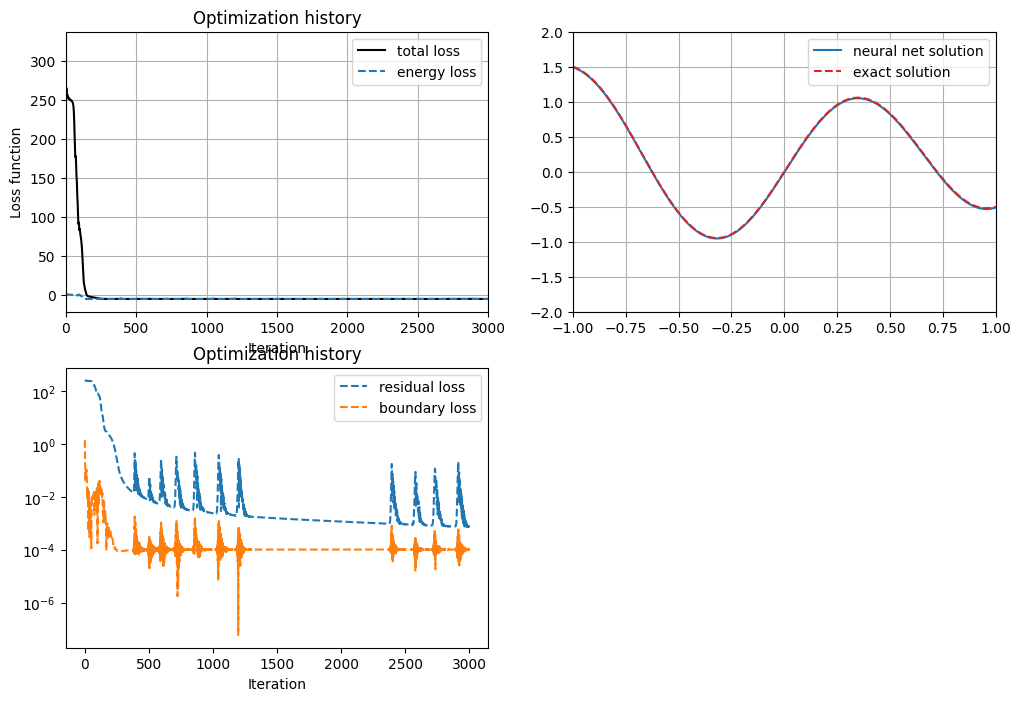

In [7]:
# Optimization loop:
hist = []
hist_r = []
hist_e = []
hist_b = []
loss = 1
loss_r = 1
itr = 1
t0 = time.time()
print("training: begin")
while (itr < itr_max + 1):
    loss, loss_r, loss_b, loss_e = train_step_DRM()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_e.append(loss_e.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
t1 = time.time()
print(f'Time: {t1-t0:.5f}s')
print("training: done")

# Compute neural net and exact solutions on a different grid:
n_plot = 1000
x_plot = np.linspace(dom[0], dom[1], n_plot)
xx_plot = tf.cast(x_plot, DTYPE)
u_pred = tf.reshape(model(tf.cast(x_plot, DTYPE)), (n_plot,))
u_ex = u_exact(x_plot)
error = np.max(np.abs(u_ex - u_pred))/np.max(np.abs(u_ex))
print(f'Error (L-inf): {error:.2e}')

# Plot loss function:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[-1,-1].axis('off')
axs[0,0].plot(range(len(hist)), hist,'k-', label='total loss')
axs[0,0].plot(range(len(hist)), hist_e, '--', label='energy loss')
axs[0,0].set_xlabel('Iteration')
axs[0,0].set_ylabel('Loss function')
axs[0,0].set_title('Optimization history')
axs[0,0].set_xlim(0, itr)
axs[0,0].grid(1)
axs[0,0].legend(loc='best', fontsize=10);

# Plot neural net and exact solutions:
axs[0,1].plot(x_plot, u_pred, label='neural net solution', color='tab:blue')
axs[0,1].plot(x_plot, u_ex, '--', label='exact solution', color='tab:red')
axs[0,1].set_xlim(dom[0], dom[1])
axs[0,1].set_ylim(-2, 2)
axs[0,1].grid(1)
axs[0,1].legend(loc='best', fontsize=10);

# Plot boundary loss and residual function:
axs[1,0].semilogy(range(len(hist)), hist_r, '--', label='residual loss')
axs[1,0].semilogy(range(len(hist)), hist_b, '--', label='boundary loss')
axs[1,0].set_xlabel('Iteration')
axs[1,0].set_title('Optimization history')
axs[1,0].legend(loc='best', fontsize=10);

# 3 Elliptic problem: PINNs with hard-encoded boundary conditions

We consider the following one-dimensional elliptic problem with non-homogeneous Dirichlet boundary conditions:

\begin{align}
& -u''(x)  = f(x), \quad x \in(-1,1), \\
& u(-1) = u_L = -1, \\
& u(+1) = u_R = +1.
\end{align}

We will take the following right-hand side and exact solution:

$$
f(x) = -6x + \omega^2\sin(\omega x), \quad u(x) = x^3 + \sin(\omega x), \quad \omega = 2\pi.
$$


We propose to hard-encode the boundary and initial condition by considering the approximation

$$
\hat{u}(x;\omega) = u^\text{BC}(x) + \phi^b(x)\hat{v}(x;\omega),
$$

with

$$
\phi^b(x) = (x-1)(x+1)
,\quad
u^\text{BC}(x) = u_L + (u_R - u_L)(x+1)/2
.
$$


### Exercise

{exercise}
Complete the missing parts in the computation of the residual. Then:

- setup a neural network model with 3 layers with 20 neurons each [Step 1];
- choose $n_r=100$ residual points [Step 2];
- try the three different 1D grids of `grid1D` [Step 2];
- choose 3000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-3}$ for the loss (`loss_min`) [Step 3].

The displayed $L^\infty$-error should be around $10^{-5}$.

In [8]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

###########################################################
# Residual
###########################################################

# ODE setup:
dom = [-1, 1]
f = lambda x: (2*np.pi)**2*tf.sin(2*np.pi*x) - 6*x
u_exact_hard_BC = lambda x: np.sin(2*np.pi*x) + x**3

# Define residual of the ODE:
def residual_hard_BC(x, u_xx):
    return -u_xx-f(x)

# Residual computation:
def compute_res_hard_BC(model, x_r):
    
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:  # replace me
        
        tape.watch(x_r)
        u = model.eval(x_r)
        u_x = tape.gradient(u,x_r)
        u_xx = tape.gradient(u_x,x_r)
        res = model.residual(x_r, u_xx)
        
    return res

# Loss function computation:
def compute_loss_hard_BC(model, x_r):    
    res = compute_res_hard_BC(model, x_r)
    loss_r = tf.reduce_mean(tf.square(res))
    loss = loss_r
    
    return loss

# Gradient computation:
def compute_grad_hard_BC(model, x_r):
    
    with tf.GradientTape(persistent=True) as tape:
        
        loss = compute_loss_hard_BC(model, x_r)
        
    grad = tape.gradient(loss, model.trainable_variables)
    
    return loss, grad


###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model([20, 20, 20])
model.residual = residual_hard_BC
model.u_boundary = lambda x: u_b[0] + (x-dom[0])*(u_b[1] - u_b[0])/(dom[1] - dom[0])
model.phi_b = lambda x: (x-dom[0])*(x-dom[1])
model.eval = lambda x: (
    tf.reshape(model.u_boundary(x),(-1,1))
     +
     tf.reshape(model.phi_b(x),(-1,1))*model(x)
    )

# Method parameters (Step 2):
n_r = 100

# Residual and boundary points, and boundary condition (Step 2):
x_r, x_b = grid1D(n_r, dom, "uniform")
u_b = tf.constant([u_exact_hard_BC(dom[0]), u_exact_hard_BC(dom[1])], shape=(2, 1), dtype=DTYPE)

# Optimization setup (Step 3):
itr_max = 3000
loss_min = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1200, 2000, 3000,6000], [1e-2, 8e-3, 5e-3, 1e-3, 5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def train_step_hard_BC():
    loss, grad = compute_grad_hard_BC(model, x_r)
    optim.apply_gradients(zip(grad, model.trainable_variables))
    
    return loss



### Validation

Time: 6.82781s
Error (L-inf): 1.27e-04


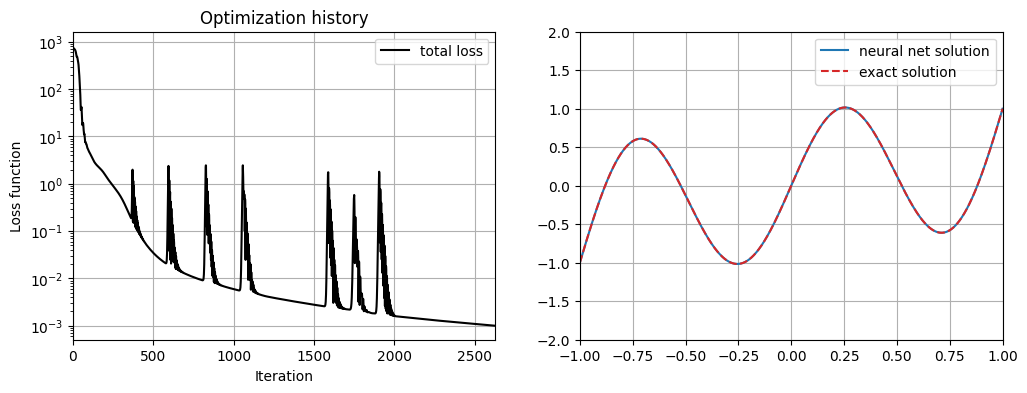

In [9]:
# Optimization loop:
hist = []
hist_r = []
hist_b = []
loss = 1
itr = 1
t0 = time.time()
while (itr < itr_max + 1 and loss > loss_min):
    loss = train_step_hard_BC()
    hist.append(loss.numpy())
    itr += 1
t1 = time.time()
print(f'Time: {t1-t0:.5f}s')

# Compute neural net and exact solutions on a different grid:
n_plot = 1000
x_plot = tf.cast(np.linspace(dom[0], dom[1], n_plot),DTYPE)
u_pred = tf.squeeze(model.eval(x_plot))
u_ex = u_exact_hard_BC(x_plot)

error = np.max(np.abs(u_ex - u_pred))/np.max(np.abs(u_ex))
print(f'Error (L-inf): {error:.2e}')

# Plot loss function:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(range(len(hist)), hist,'k-', label='total loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss function')
axs[0].set_title('Optimization history')
axs[0].set_xlim(0, itr)
axs[0].grid(1)
axs[0].legend(loc='best', fontsize=10);

# Plot neural net and exact solutions:
axs[1].plot(x_plot, u_pred, label='neural net solution', color='tab:blue')
axs[1].plot(x_plot, u_ex, '--', label='exact solution', color='tab:red')
axs[1].set_xlim(dom[0], dom[1])
axs[1].set_ylim(-2, 2)
axs[1].grid(1)
axs[1].legend(loc='best', fontsize=10);

# 4 Viscous Burgers equation

We consider the one-dimensional viscous Burgers' equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& u_t(t,x) + u u_x = \beta u_{xx}(x,t), && t\in[0,T], \quad x\in(-1,1), \\
& u(t,x) = u(t,x) = 0, && t\in[0,T], \\
& u(0,x) = u_0(x), && x\in(-1,1).
\end{align}

We will take $T=0.5$, $\beta = 10^{-2}/\pi$ and the following intial condition

$$
u_0(x) = - \sin(\pi x).
$$

## 4.1 Soft Boundary conditions

### Exercise

{exercise}
Complete the missing parts in the computation of the residual, loss, and gradient. Then:

- setup a neural network model with 5 layers with 25 neurons each [Step 1];
- choose $\gamma=10$, $n_r=200$ residual points, and $n_b=n_i=20$ boundary points [Step 2];
- setup the grid with `grid2D` [Step 2];
- choose 5000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-3}$ for the loss (`loss_min`) [Step 3].

The displayed $L^1$-error should be around $10^{-2}$ for the initial instant and $10^{-1}$ for the final instant.

In [10]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

###########################################################
# Residual, loss, and gradient
###########################################################

# PDE setup
beta = 1e-2/np.pi
T = 0.5
dom = [0, T, -1, 1]
u0 = lambda x: - tf.sin(np.pi * x)

# Define residual of the PDE:
def residual_burgers(x, u, u_t, u_x, u_xx):
    return u_t+u*u_x-beta*u_xx

# Residual computation:
def compute_res_burgers(model, X_r):
    
    t_r = X_r[:, 0:1]
    x_r = X_r[:, 1:2]
    
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape: # replace me
        
        tape.watch(t_r)
        tape.watch(x_r)
        g = tf.stack([t_r[:, 0], x_r[:, 0]], axis=1)
        u = model(g)
        u_t = tape.gradient(u,t_r)
        u_x = tape.gradient(u,x_r)
        u_xx = tape.gradient(u_x,x_r)
        res = model.residual(X_r, u, u_t, u_x, u_xx)
            
        return res

# Loss function computation:
def compute_loss_burgers(model, X_r, X_b, u_b, gamma):
    
    # Loss on residual:
    res = compute_res_burgers(model, X_r)
    loss_r = tf.reduce_mean(tf.square(res))
    
    # Loss on boundary points:
    u_pred = model(X_b)
    loss_b = tf.reduce_mean(tf.square(u_pred - u_b))
    
    # Total loss:
    loss = loss_r+gamma*loss_b
        
    return loss, loss_r, loss_b

# Gradient computation:
def compute_grad_burgers(model, X_r, X_b, u_b, gamma=1):
    
    with tf.GradientTape(persistent=True) as tape:
        loss, loss_r, loss_b = compute_loss_burgers(model, X_r, X_b, u_b, gamma)
    grad = tape.gradient(loss, model.trainable_variables)
    
    return loss, grad, loss_r, loss_b

###########################################################
# Algorithm
###########################################################

# Initialize neural network model (Step 1):
model = create_model([25, 25, 25, 25, 25], input_size=2)
model.residual = residual_burgers

# Method parameters (Step 2):
gamma = 10
n_r = 200
n_b = 20
n_i = 20

# Residual and boundary points, and boundary condition (Step 2):
X_r, X_b, u_b =  grid2D(n_r, n_b, n_i, dom)

# Optimization setup (Step 3):
itr_max = 5000
loss_min = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def train_step_burgers():

    loss, grad, loss_r, loss_b = compute_grad_burgers(model, X_r, X_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))
    
    return loss, loss_r, loss_b

### Validation

Time: 19.66035s
Error at initial instant (L-1): 3.55e-02
Error at final instant (L-1): 8.40e-02


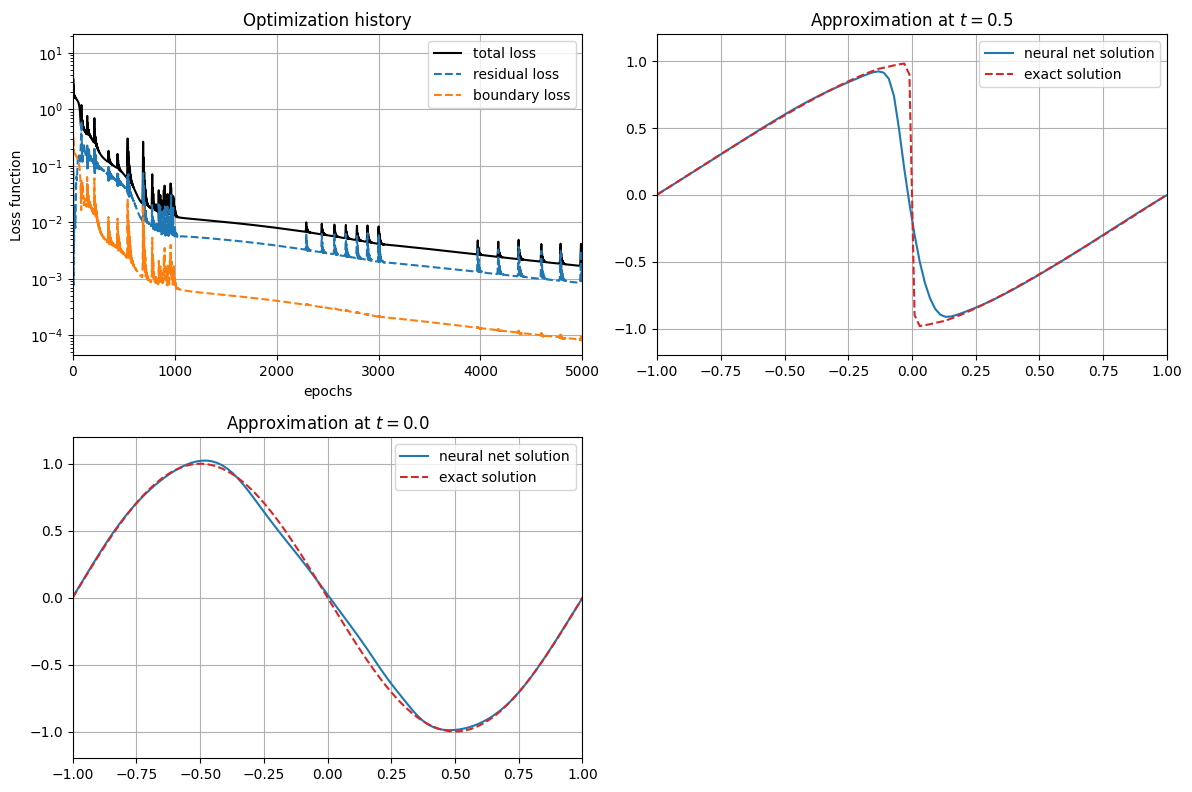

In [11]:
# Optimization loop:
hist = []
hist_r = []
hist_b = []
loss = 1
itr = 1
t0 = time.time()
while (itr < itr_max + 1 and loss > loss_min):
    loss, loss_r, loss_b = train_step_burgers()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
t1 = time.time()
print(f'Time: {t1-t0:.5f}s')

# Compute neural net and exact solutions on a different grid:
n_plot = 100
x_plot = np.linspace(-1, 1, n_plot)

xt_plot = tf.stack([tf.linspace(0,1,10)*0.0,tf.linspace(0,1,10)],axis=1)
xt_plot_final = tf.stack([T*tf.ones_like(x_plot),x_plot],axis=1)
xt_plot_initial = tf.stack([tf.zeros_like(x_plot),x_plot],axis=1)
u_pred_final = tf.squeeze(model(xt_plot_final))
u_pred_initial = tf.squeeze(model(xt_plot_initial))
u_ex_initial = tf.cast(u0(x_plot),dtype=DTYPE)
u_ex_final = np.loadtxt('viscous-burgers-uref.txt')[:,1]

error_initial = np.linalg.norm(u_ex_initial - u_pred_initial,ord=1)/np.linalg.norm(u_ex_initial,ord=1)
error_final = np.linalg.norm(u_ex_final - u_pred_final,ord=1)/np.linalg.norm(u_ex_final,ord=1)

print(f'Error at initial instant (L-1): {error_initial:.2e}')
print(f'Error at final instant (L-1): {error_final:.2e}')

# Plot loss function:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[-1,-1].axis('off')

axs[0,0].semilogy(range(len(hist)), hist,'k-', label='total loss')
axs[0,0].semilogy(range(len(hist)), hist_r, '--', label='residual loss')
axs[0,0].semilogy(range(len(hist)), hist_b, '--', label='boundary loss')
axs[0,0].set_xlabel('epochs')
axs[0,0].set_ylabel('Loss function')
axs[0,0].set_title('Optimization history')
axs[0,0].set_xlim(0, itr)
axs[0,0].grid(1)
axs[0,0].legend(loc='best', fontsize=10);

# Plot neural net and exact solutions:
axs[0,1].plot(x_plot, u_pred_final, label='neural net solution', color='tab:blue')
axs[0,1].plot(x_plot, u_ex_final, '--', label='exact solution', color='tab:red')
axs[0,1].set_xlim(dom[2], dom[3])
axs[0,1].set_ylim(-1.2, 1.2)
axs[0,1].grid(1)
axs[0,1].legend(loc='best', fontsize=10);
axs[0,1].set_title(f'Approximation at $t={T}$')


# Plot neural net and exact solutions:
axs[1,0].plot(x_plot, u_pred_initial, label='neural net solution', color='tab:blue')
axs[1,0].plot(x_plot, u_ex_initial, '--', label='exact solution', color='tab:red')
axs[1,0].set_xlim(dom[2], dom[3])
axs[1,0].set_ylim(-1.2, 1.2)
axs[1,0].grid(1)
axs[1,0].legend(loc='best', fontsize=10);
axs[1,0].set_title(f'Approximation at $t={0.0}$')

fig.tight_layout(pad=1.0)

## 4.2 Hard encoded initial and boundary conditions

We will tackle the same problem as in section 4.1 with a different approach.

We propose to hard-encode the boundary and initial condition by considering the approximation

$$
\hat{u}(t,x;\omega) = u_0(t) + \phi^b(t,x)\hat{v}(t,x;\omega),
$$

with

$$
\phi^b(t,x) = \sqrt{t}(x-1)(x+1).
$$

### Exercise

{exercise}
Complete the missing parts in the computation of the residual. Then:

- setup a neural network model with 5 layers with 25 neurons each [Step 1];
- choose $n_r=200$ residual points, and $n_b=n_i=20$ boundary points [Step 2];
- setup the grid with `grid2D` [Step 2];
- choose 5000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-3}$ for the loss (`loss_min`) [Step 3].


The displayed $L^1$-error should be around $0$ at machine precision for the initial instant and $10^{-2}$ for the final instant.

In [12]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

###########################################################
# Residual
###########################################################

# PDE setup:
beta = 1e-2/np.pi
T = 0.5
dom = [0, T, -1, 1]
u0 = lambda x: - tf.sin(np.pi * x)

# Residual computation:
def compute_res_burgers_hard_bcic(model, X_r):
    
    t_r = X_r[:, 0:1]
    x_r = X_r[:, 1:2]
    
    with tf.GradientTape(persistent=True) as tape:
        
        tape.watch(t_r)
        tape.watch(x_r)
        g = tf.stack([t_r[:, 0], x_r[:, 0]], axis=1)
        u = model.eval(t_r,x_r)
        u_t = tape.gradient(u,t_r)
        u_x = tape.gradient(u,x_r)
        u_xx = tape.gradient(u_x,x_r)
        res = model.residual(X_r, u, u_t, u_x, u_xx)
            
        return res


# Loss function computation:
def compute_loss_burgers_hard_bcic(model, X_r):
    # Loss on residual:
    res = compute_res_burgers_hard_bcic(model, X_r)
    loss_r = tf.reduce_mean(tf.square(res))
    loss = loss_r
    
    return loss

# Gradient computation:
def compute_grad_burgers_hard_bcic(model, X_r):
    
    with tf.GradientTape(persistent=True) as tape:
        loss = compute_loss_burgers_hard_bcic(model, X_r)
    grad = tape.gradient(loss, model.trainable_variables)
    
    return loss, grad

###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model([25, 25, 25, 25, 25], input_size=2)
model.residual = residual_burgers
model.u0 = lambda t,x: u0(x)
model.phi_b = lambda t,x: (t**0.5)*(x-dom[2])*(x-dom[3])
model.eval = lambda t,x : (
    tf.reshape(model.u0(t,x),(-1,1))
     +
     tf.reshape(model.phi_b(t,x), (-1,1)) * tf.reshape(model(tf.stack([t,x],axis=1)),(-1,1))
    )

# Method parameters (Step 2):
n_r = 200
n_b = 20
n_i = 20

# Residual and boundary points, and boundary condition (Step 2):
X_r, X_b, u_b =  grid2D(n_r, n_b, n_i, dom)

# Optimization setup (Step 3):
itr_max = 5000
loss_min = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def train_step_burgers_hard_bcic():

    loss,grad = compute_grad_burgers_hard_bcic(model, X_r)
    optim.apply_gradients(zip(grad, model.trainable_variables))
    
    return loss

### Validation

Time: 7.97616s
Error at initial instant (L-1): 0.00e+00
Error at final instant (L-1): 6.43e-02


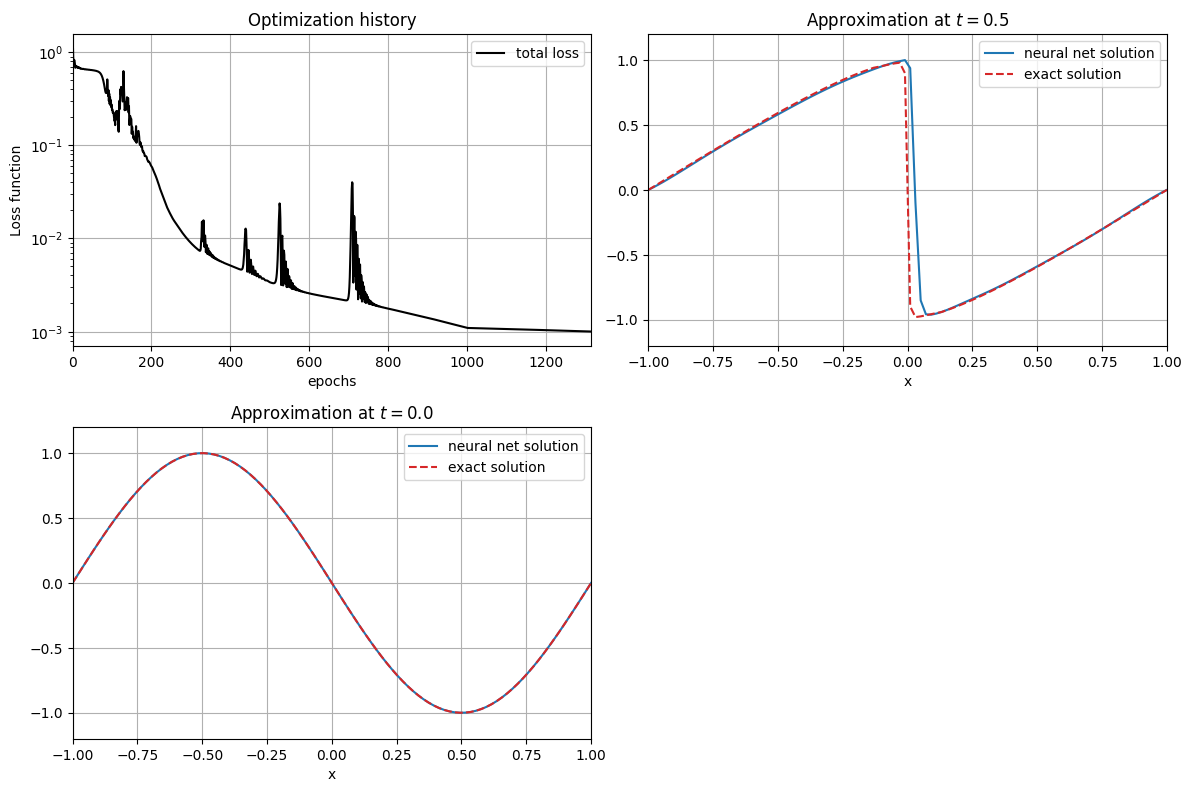

In [13]:
# Optimization loop:
hist = []
hist_r = []
hist_b = []
loss = 1
itr = 1
t0 = time.time()
while (itr < itr_max + 1 and loss > loss_min):
    loss = train_step_burgers_hard_bcic()
    hist.append(loss.numpy())
    itr += 1
t1 = time.time()
print(f'Time: {t1-t0:.5f}s')

# Compute neural net and exact solutions on a different grid:
n_plot = 100
x_plot = tf.linspace(tf.constant(dom[2],dtype=DTYPE), tf.constant(dom[3],dtype=DTYPE), n_plot)

tx_plot_final = tf.stack([T*tf.ones_like(x_plot),x_plot],axis=1)
tx_plot_initial = tf.stack([tf.zeros_like(x_plot),x_plot],axis=1)

t_plot_final = T*tf.ones_like(x_plot)
t_plot_initial = tf.zeros_like(x_plot)

u_pred_final = tf.squeeze(model.eval(t_plot_final,x_plot))
u_pred_initial = tf.squeeze(model.eval(t_plot_initial,x_plot))

u_ex_initial = tf.cast(u0(x_plot),dtype=DTYPE)
u_ex_final = np.loadtxt('viscous-burgers-uref.txt')[:,1]

error_initial = np.linalg.norm(u_ex_initial - u_pred_initial,ord=1)/np.linalg.norm(u_ex_initial,ord=1)
error_final = np.linalg.norm(u_ex_final - u_pred_final,ord=1)/np.linalg.norm(u_ex_final,ord=1)

print(f'Error at initial instant (L-1): {error_initial:.2e}')
print(f'Error at final instant (L-1): {error_final:.2e}')


# Plot loss function:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[-1,-1].axis('off')

axs[0,0].semilogy(range(len(hist)), hist,'k-', label='total loss')
# axs[0,0].semilogy(range(len(hist)), hist_r, '--', label='residual loss')
# axs[0,0].semilogy(range(len(hist)), hist_b, '--', label='boundary loss')
axs[0,0].set_xlabel('epochs')
axs[0,0].set_ylabel('Loss function')
axs[0,0].set_title('Optimization history')
axs[0,0].set_xlim(0, itr)
axs[0,0].grid(1)
axs[0,0].legend(loc='best', fontsize=10);

# Plot neural net and exact solutions:
axs[0,1].plot(x_plot, u_pred_final, label='neural net solution', color='tab:blue')
axs[0,1].plot(x_plot, u_ex_final, '--', label='exact solution', color='tab:red')
axs[0,1].set_xlim(dom[2], dom[3])
axs[0,1].set_ylim(-1.2, 1.2)
axs[0,1].grid(1)
axs[0,1].set_xlabel('x')
axs[0,1].legend(loc='best', fontsize=10);
axs[0,1].set_title(f'Approximation at $t={T}$')


# Plot neural net and exact solutions:
axs[1,0].plot(x_plot, u_pred_initial, label='neural net solution', color='tab:blue')
axs[1,0].plot(x_plot, u_ex_initial, '--', label='exact solution', color='tab:red')
axs[1,0].set_xlim(dom[2], dom[3])
axs[1,0].set_ylim(-1.2, 1.2)
axs[1,0].set_xlabel('x')
axs[1,0].grid(1)
axs[1,0].legend(loc='best', fontsize=10);
axs[1,0].set_title(f'Approximation at $t={0.0}$')

fig.tight_layout(pad=1.0)

# 5 Fourier features

We consider the following one-dimensional elliptic problem with homogeneous Dirichlet boundary conditions:

\begin{align}
& -u''(x)  = f(x), \quad x \in(-1,1), \\
& u(-1) = u_L = -1 \\
& u(+1) = u_R = +1.
\end{align}

We will take the following right-hand side and exact solution that involves two frequencies:

$$
f(x) = \alpha^2\sin(\alpha x) + 0.1\times\beta^2\sin(\beta x),
\quad
u(x) = \sin(\alpha x) + 0.1 \sin(\beta x)
,\quad
\alpha = 2\pi,\, \beta = 8 \alpha
.
$$

We propose to first use the classic approach of pc5 (using soft boundary conditions) with a classical MLP network. Then we will use the same training with a neural network architecture that implement Fourier features.

## 5.1 Elliptic problem with high frequencies: classical approach

### Exercise

{exercise}
Complete the missing parts in the computation of the energy, residual, loss, and gradient. Then:

- setup a neural network model with 3 layers with 14 neurons each [Step 1];
- choose $\gamma=10$ and $n_r=100$ residual points [Step 2];
- try the three different 1D grids of `grid1D` [Step 2];
- choose 2000 iterations maximum (`itr_max`) [Step 3].

The displayed $L^\infty$-error may be large.

In [14]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ODE setup:
dom= [-1, 1]
alpha = 2*np.pi
beta= 8*alpha
f = lambda x: (alpha)**2*tf.sin(alpha*x) + 0.1*(beta)**2*tf.sin(beta*x)
u_exact= lambda x: np.sin(alpha*x) + 0.1*np.sin(beta*x)

# Define residual of the ODE:
def residual_FF(x, u_xx):
    return -u_xx-f(x)


# Residual computation:
def compute_res_FF(model, x_r):
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape: # replace me
        tape.watch(x_r)
        u = model(x_r)
        u_x = tape.gradient(u,x_r)
        u_xx = tape.gradient(u_x,x_r)
        res = model.residual(x_r, u_xx)
    return res

# Loss function computation:
def compute_loss_FF(model, X_r, X_b, u_b, gamma):
    # Loss on residual:
    res = compute_res_FF(model, x_r)
    loss_r = tf.reduce_mean(tf.square(res))

    # Loss on boundary points:
    u_pred = model(X_b)
    loss_b = tf.reduce_mean(tf.square(u_pred - u_b))

    # Total loss:
    loss = loss_r+gamma*loss_b

    return loss, loss_r, loss_b

# Gradient computation:
def compute_grad_FF(model, X_r, X_b, u_b, gamma=1):

    with tf.GradientTape(persistent=True) as tape:

        loss, loss_r, loss_b = compute_loss_FF(model, X_r, X_b, u_b, gamma)

    grad = tape.gradient(loss, model.trainable_variables)

    return loss, grad, loss_r, loss_b



###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model([14, 14, 14])
model.residual = residual_FF

# Method parameters (Step 2):
gamma = 10 # replace me
n_r = 100 # replace me

# Residual and boundary points, and boundary condition (Step 2):
x_r, x_b= grid1D(n_r, dom, "uniform")
u_b= tf.constant([u_exact(dom[0]), u_exact(dom[1])], shape=(2, 1), dtype=DTYPE)
x_r= tf.reshape(x_r, (-1, 1))
x_b= tf.reshape(x_b, (-1, 1))

# Optimization setup (Step 3):
itr_max = 2000
loss_min = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1200, 2000, 3000, 6000], [5e-2, 1e-2, 5e-3,5e-3, 1e-3])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def train_step_FF():
    loss, grad, loss_r, loss_b= compute_grad_FF(model, x_r, x_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    return loss, loss_r, loss_b



### Validation

training: begin
Time: 5.72431s
training: done
Error (L-inf): 1.00e+00


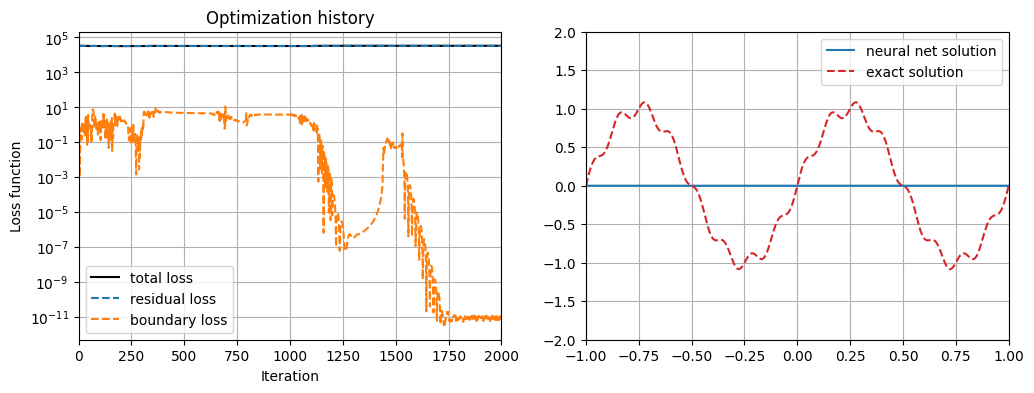

In [15]:
# Optimization loop:
hist= []
hist_r= []
hist_b= []
loss= 1
itr= 1
t0= time.time()
print("training: begin")
for itr in range(itr_max):
    loss, loss_r, loss_b = train_step_FF()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
    if (loss < loss_min):
        break
t1= time.time()
print(f'Time: {t1-t0:.5f}s')
print("training: done")

# Compute neural net and exact solutions on a different grid:
n_plot= 1000
x_plot= np.linspace(dom[0], dom[1], n_plot)
xx_plot= tf.cast(x_plot, DTYPE)
xx_plot= tf.reshape(xx_plot, (-1, 1))
u_pred= model(xx_plot)
u_pred = tf.reshape(u_pred, (n_plot,))

u_ex= u_exact(x_plot)
error= np.max(np.abs(u_ex - u_pred))/np.max(np.abs(u_ex))
print(f'Error (L-inf): {error:.2e}')

# Plot loss function:
fig, axs= plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(range(len(hist)), hist, 'k-', label='total loss')
axs[0].semilogy(range(len(hist)), hist_r, '--', label='residual loss')
axs[0].semilogy(range(len(hist)), hist_b, '--', label='boundary loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss function')
axs[0].set_title('Optimization history')
axs[0].set_xlim(0, itr)
axs[0].grid(1)
axs[0].legend(loc='best', fontsize=10);

# Plot neural net and exact solutions:
axs[1].plot(x_plot, u_pred, label='neural net solution', color='tab:blue')
axs[1].plot(x_plot, u_ex, '--', label='exact solution', color='tab:red')
axs[1].set_xlim(dom[0], dom[1])
axs[1].set_ylim(-2, 2)
axs[1].grid(1)
axs[1].legend(loc='best', fontsize=10);

## 5.2 Elliptic problem with high frequencies: Fourier features

We now propose to implement Fourier features by creating a modified version of the `create_model()`routine. We proceede by taking advantage of the `Dense()` Keras layer with a sine activation function. This layer will be the first hidden layer of the neural net. 
We will choose the set of weights and biases randomly (with a uniform distribution) at the creation of the model and lock the values so that they are not modified during the training.

### Exercise

{exercise}
Complete the following code. The layer of Fourier feature will include `num_fourier_features` sine functions and `num_fourier_features` cosine functions (sine functions with a $\pi/2$ bias). The weights of this layer will be randomly chosen following a normal distribution with mean 0 and a standard deviation equal to 10.
Then:

- setup a neural network model with 2 layers with 20 neurons each (accounting for the Fourier features layer the total number of hidden layer will then be 3) and 10 Fourier features [Step 1];
- choose $\gamma=10$ and $n_r=100$ residual points [Step 2];
- try the three different 1D grids of `grid1D` [Step 2];
- choose 2000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-3}$ for the loss (`loss_min`) [Step 3]

The displayed $L^\infty$-error about $10^{-2}$.

```

In [16]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def create_model_FF(neurons, *, input_size=1, output_size=1, activation="sigmoid", initializer="glorot_normal", num_fourier_features=10):
    """
    Creates a Sequential Keras model with the specified parameters with a Fourier feature layer.

        Parameters
        ----------
        neurons : list of int
            A list where each element represents the number of neurons in a hidden layer.
        input_size : int, optional
            The size of the input layer. Default is 1.
        output_size : int, optional
            The size of the output layer. Default is 1.
        activation : str, optional
            The activation function to use for the hidden layers. Default is 'tanh'.
        initializer : str, optional
            The initializer for the kernel weights matrix. Default is 'glorot_normal'.

        Returns
        -------
        tf.keras.Sequential
            A Keras Sequential model with the specified architecture.
    """
    # Setup model:
    model = tf.keras.Sequential()

    # Input layer:
    model.add(tf.keras.Input(shape=(input_size,)))

    # This is the initializer for the Fourier features layer
    ff_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=10, seed=42)

    model.add(tf.keras.layers.Dense(
        2*num_fourier_features, 
        activation=tf.sin, 
        kernel_initializer=ff_initializer,
        trainable=False
        ))
    
    # set the coefficients of the FF layer
    ff_coef = np.random.normal(loc=0.0, scale=10, size=num_fourier_features)
    ff_coef_weights = np.concatenate([ff_coef,ff_coef]).reshape(1,-1)
    ff_coef_biases = np.concatenate([np.zeros(num_fourier_features),0.5*np.pi*np.ones(num_fourier_features)])
    model.layers[0].set_weights([ff_coef_weights,ff_coef_biases])

    # Loop over hidden layers:
    for dl in neurons:
        model.add(tf.keras.layers.Dense(
            dl, activation=activation, kernel_initializer=initializer))

    # Output layer:
    model.add(tf.keras.layers.Dense(output_size))
    model.num_output= output_size

    return model




###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model_FF([20, 20])
model.residual = residual_FF

# Method parameters (Step 2):
gamma = 10
n_r = 100

# Residual and boundary points, and boundary condition (Step 2):
x_r, x_b = grid1D(n_r, dom, "uniform")
u_b = tf.constant([u_exact(dom[0]), u_exact(dom[1])], shape=(2, 1), dtype=DTYPE)
x_r = tf.reshape(x_r, (-1, 1))
x_b = tf.reshape(x_b, (-1, 1))

# Optimization setup (Step 3):
itr_max = 2000
loss_min = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1200, 2000, 3000, 6000], [5e-2, 1e-2, 5e-3,5e-3, 1e-3])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def train_step_FF():
    loss, grad, loss_r, loss_b= compute_grad_FF(model, x_r, x_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    return loss, loss_r, loss_b

### Validation

training: begin
Time: 4.61528s
training: done
Error (L-inf): 1.85e-02


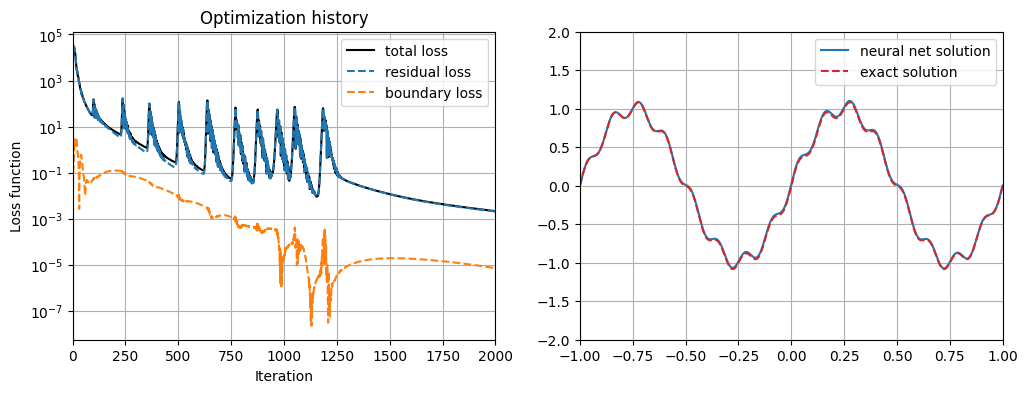

In [17]:
# Optimization loop:
hist= []
hist_r= []
hist_b= []
loss= 1
itr= 1
t0= time.time()
print("training: begin")
for itr in range(itr_max):
    loss, loss_r, loss_b = train_step_FF()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
    if (loss < loss_min):
        break
t1= time.time()
print(f'Time: {t1-t0:.5f}s')
print("training: done")

# Compute neural net and exact solutions on a different grid:
n_plot= 1000
x_plot= np.linspace(dom[0], dom[1], n_plot)
xx_plot= tf.cast(x_plot, DTYPE)
xx_plot= tf.reshape(xx_plot, (-1, 1))

u_pred= model(xx_plot)

u_pred = tf.reshape(u_pred, (n_plot,))

u_ex= u_exact(x_plot)
error= np.max(np.abs(u_ex - u_pred))/np.max(np.abs(u_ex))
print(f'Error (L-inf): {error:.2e}')

# Plot loss function:
fig, axs= plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(range(len(hist)), hist, 'k-', label='total loss')
axs[0].semilogy(range(len(hist)), hist_r, '--', label='residual loss')
axs[0].semilogy(range(len(hist)), hist_b, '--', label='boundary loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss function')
axs[0].set_title('Optimization history')
axs[0].set_xlim(0, itr)
axs[0].grid(1)
axs[0].legend(loc='best', fontsize=10);

# Plot neural net and exact solutions:
axs[1].plot(x_plot, u_pred, label='neural net solution', color='tab:blue')
axs[1].plot(x_plot, u_ex, '--', label='exact solution', color='tab:red')
axs[1].set_xlim(dom[0], dom[1])
axs[1].set_ylim(-2, 2)
axs[1].grid(1)
axs[1].legend(loc='best', fontsize=10);

